# Flow Calculation
In this notebook, we present the approach we used to estimate the incoming and outgoing water flow rates of the two tanks in our system.

### Detection of the water volume in an image
To be able to detect the volume of water present inside the tanks of the system at any given time, the function mapping the water level in a tank to the volume it contains needs to be learned. This is done as follows.

First, pictures of the system with volumes of water varying from 0.0 to 1.4 litres in steps of 0.1L are taken. For each volume, 3 different images are captured. Below, samples of the photos taken during this phase are shown.

Populating the interactive namespace from numpy and matplotlib


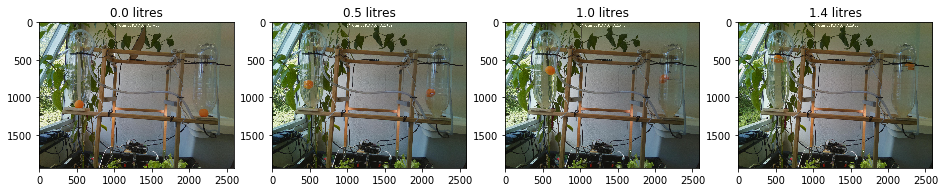

In [6]:
import os
import imageio
import matplotlib.pyplot as plt

imgs = []
for img in os.listdir('files/volumes'):
    if img.endswith('.jpg'):
        imgs.append((float('.'.join(img.split('.')[0:2])),
                     imageio.imread(os.path.join('files/volumes', img))))

names, images = zip(*sorted(imgs))

%pylab inline
pylab.rcParams['figure.figsize'] = (16, 6)

fig = plt.figure()
for i in range(4):
    ax = fig.add_subplot(1,4,i+1)
    ax.imshow(images[i])
    ax.set_title(str(names[i])+' litres')

The water level in the photos is then detected with the help of the image recognition algorithm presented in the *ImageRecognition* notebook. The example for the right tank is illustrated below.

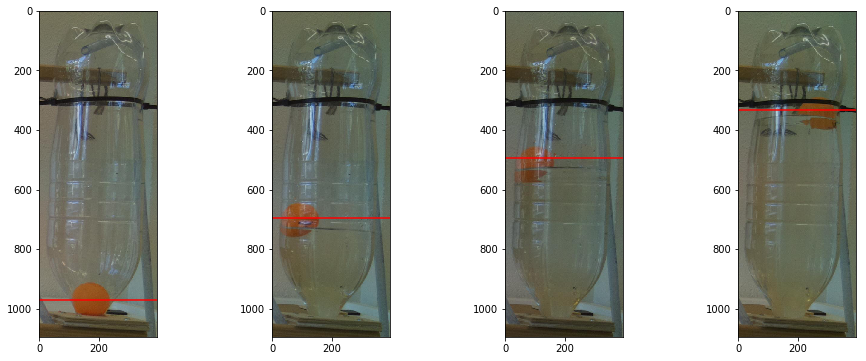

In [7]:
from utils import crop_image, detect_ball, show_height

right_crop = dict(topleft=(240, 2015), bottomright=(1335, 2410))

fig = plt.figure()
for i, image in enumerate(images):
    cropped_image = crop_image(image, right_crop['topleft'], right_crop['bottomright'])
    (_, ball_y) = detect_ball(cropped_image, 80)
    ax = fig.add_subplot(1,4,i+1)
    ax.imshow(cropped_image)
    ax.axhline(y=ball_y, color='r')

The average of the water levels in the 3 images is computed for each volume. Since the amount of water is known in the images, a trace of the volume given the average water level (or ball height) can be produced. A polynomial regression is applied on this trace to approximate the function that maps the water level to the volume.

Text(0.5,1,"Water volume in the right tank given the ball's height")

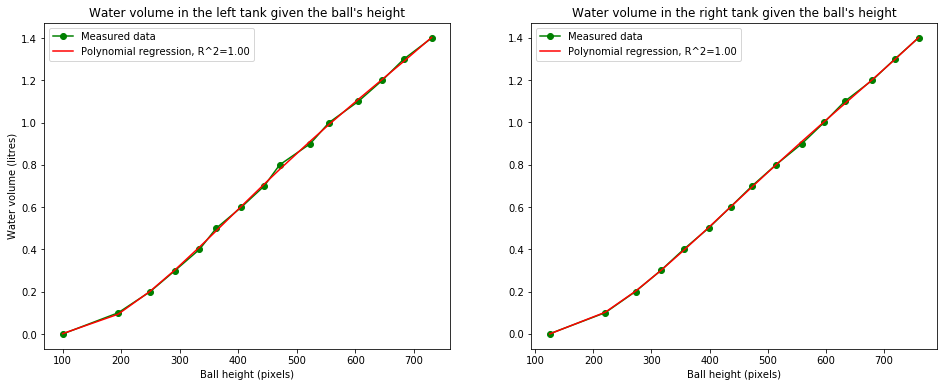

In [8]:
from utils import load_data
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

    
# The traces of the water volume given the ball height for the left and right tank
# are loaded.
x_left, y_left = load_data('files/height_volume_left.csv')
x_right, y_right = load_data('files/height_volume_right.csv')

# Polynomial regressions are fit on the traces.
x_powers_left = np.c_[x_left, np.square(x_left), np.power(x_left, 3), np.power(x_left, 4)]
x_powers_right = np.c_[x_right, np.square(x_right), np.power(x_right, 3), np.power(x_right, 4)]

reg_left = LinearRegression()
reg_left.fit(x_powers_left, y_left)
y_pred_left = reg_left.predict(x_powers_left)
r2_left = r2_score(y_left, y_pred_left)

reg_right = LinearRegression()
reg_right.fit(x_powers_right, y_right)
y_pred_right = reg_right.predict(x_powers_right)
r2_right = r2_score(y_right, y_pred_right)

# Plot of the results.
fig = plt.figure()
ax1 = fig.add_subplot(1,2,1)
ax1.plot(x_left, y_left, '-og')
ax1.plot(x_left, y_pred_left, '-r')
ax1.legend(["Measured data",
            "Polynomial regression, R^2={:.2f}".format(r2_left)])
ax1.set_title("Water volume in the left tank given the ball's height")
plt.xlabel('Ball height (pixels)')
plt.ylabel('Water volume (litres)')

ax2 = fig.add_subplot(1,2,2)
ax2.plot(x_right, y_right, '-og')
ax2.plot(x_right, y_pred_right, '-r')
ax2.legend(["Measured data",
            "Polynomial regression, R^2={:.2f}".format(r2_right)])
plt.xlabel('Ball height (pixels)')
ax2.set_title("Water volume in the right tank given the ball's height")

When an unknown volume of water present in a tank has to be estimated, a photo of the system is taken, the height of the ball is detected, and the regression is used to get the corresponding volume.

In [21]:
from utils import get_ball_height

image = imageio.imread('files/system_image.jpg')

ball_height = get_ball_height(image, 80, right_crop['topleft'], right_crop['bottomright'])

height_powers = np.c_[ball_height, np.square(ball_height), np.power(ball_height, 3), np.power(ball_height, 4)]

volume = reg_right.predict(height_powers)
print("Volume of water in the image: {:.2f} litres".format(volume[0][0]))

Volume of water in the image: 0.91 litres


### Volume/time traces
TODO

In [ ]:
# The traces of the water volume over time for the left and right tank
# are loaded.
xflow_left, yflow_left = load_data('files/time_volume_left.csv')
xflow_right, yflow_right = load_data('files/time_volume_right.csv')

fig = plt.figure()
ax1 = fig.add_subplot(1,2,1)
ax1.plot(xflow_left, yflow_left, 'o')
ax1.set_title("Left tank")
plt.xlabel('time (seconds)')
plt.ylabel('volume (litres)')
ax2 = fig.add_subplot(1,2,2)
ax2.plot(xflow_right, yflow_right, 'o')
ax2.set_title("Right tank")
plt.xlabel('time (seconds)')

### Regression on the traces
TODO

### Estimation of the flow rates
TODO